In [1]:
#############Load train and test data--- Declare Column Names####################

import pandas as pd
import numpy as np

data = pd.read_csv("KDD-train-full.csv")
test_data = pd.read_csv("KDD-test-full.csv")

col_names = np.array(["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","labels","count"])

nominal_inx = [1, 2, 3]
binary_inx = [6, 11, 13, 14, 20, 21]
numeric_inx = list(set(range(41)).difference(nominal_inx).difference(binary_inx))

nominal_cols = col_names[nominal_inx].tolist()
binary_cols = col_names[binary_inx].tolist()
numeric_cols = col_names[numeric_inx].tolist()

print("Training Data shape: ", data.shape)
print("Test Data shape:", test_data.shape)



Training Data shape:  (125973, 43)
Test Data shape: (22543, 43)


In [2]:
###########################Create attack dictionary Mapping attack type to four major attack categories##########

attack_dict = {
    'normal': 'normal',
    
    'back': 'DoS',
    'land': 'DoS',
    'neptune': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'teardrop': 'DoS',
    'mailbomb': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'udpstorm': 'DoS',
    
    'ipsweep': 'Probe',
    'nmap': 'Probe',
    'portsweep': 'Probe',
    'satan': 'Probe',
    'mscan': 'Probe',
    'saint': 'Probe',

    'ftp_write': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'multihop': 'R2L',
    'phf': 'R2L',
    'spy': 'R2L',
    'warezclient': 'R2L',
    'warezmaster': 'R2L',
    'sendmail': 'R2L',
    'named': 'R2L',
    'snmpgetattack': 'R2L',
    'snmpguess': 'R2L',
    'xlock': 'R2L',
    'xsnoop': 'R2L',
    'worm': 'R2L',
    
    'buffer_overflow': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R',
    'rootkit': 'U2R',
    'httptunnel': 'U2R',
    'ps': 'U2R',    
    'sqlattack': 'U2R',
    'xterm': 'U2R'
}

In [3]:
############################## Create function which maps attack type to 4 defined categories for each record#################

def create_attack_label(row):
    return attack_dict[row['labels']]

#############Convert labels in train and test data to new labels####################

data['label5'] = data.apply(lambda x : create_attack_label(x), axis = 1)

test_data['label5'] = test_data.apply(lambda x : create_attack_label(x), axis = 1)

print("Train data shape:", data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (125973, 44)
Test data shape: (22543, 44)


In [4]:
############### Check data distribution across labels in train and test data ########################

print(data.groupby('label5').agg({'count':'count'}))
print(test_data.groupby('label5').agg({'count':'count'}))

        count
label5       
DoS     45927
Probe   11656
R2L       995
U2R        52
normal  67343
        count
label5       
DoS      7458
Probe    2421
R2L      2754
U2R       200
normal   9710


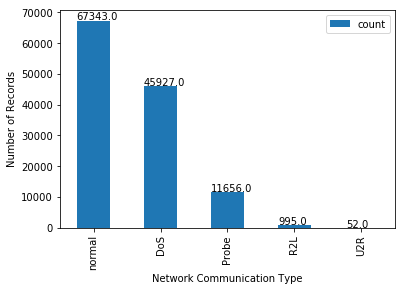

In [5]:
########### Check visual data distribution ######################

from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
###########################################

import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

ax = data.groupby("label5").agg({'count':'count'}).sort_values(by = 'count',ascending=False).plot(kind='bar')
ax.set_xlabel("Network Communication Type")
ax.set_ylabel("Number of Records")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

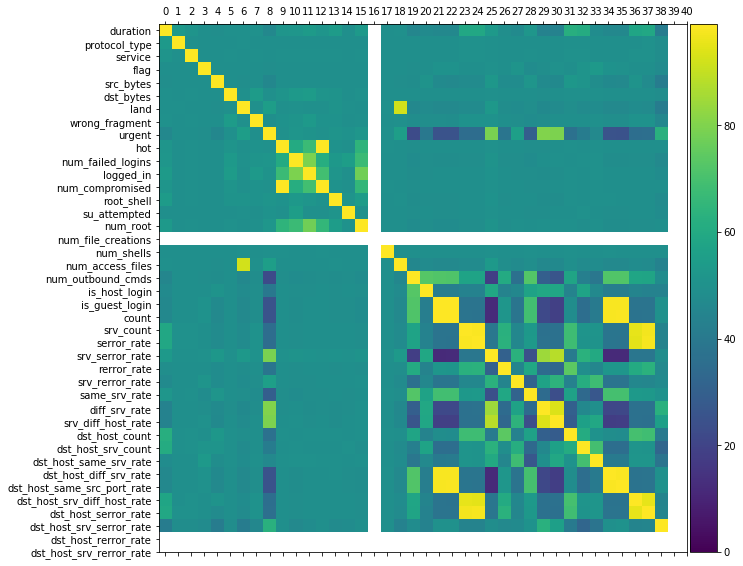

In [6]:
################## Plot correlation metrics #################

correlations = pd.DataFrame()
correlations = data.corr()

# plot correlation matrix
fig = pl.figure(figsize=(10,10))
ax1 = pl.gca()

im = ax1.imshow(np.arange(100).reshape((10,10)))
cax = ax1.matshow(correlations, vmin=-1, vmax=1)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax)
ticks = np.arange(0,41,1)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)

# X axis tick labels are not set as the plot looks clumpsy
ax1.set_yticklabels(col_names)
pl.show()

In [7]:
######################### Pre-process training and testing data ##############################
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report


###################### Extract labels and features from train and test data ###################

labels_raw = data['label5']
features_raw = data.drop(['labels','count','label5'],axis=1)

labels_test_raw = test_data['label5']
features_test_raw = test_data.drop(['labels','count','label5'],axis=1)


#################### Convert categorical features to numeric using LabelEncoder ##################

encoder = LabelEncoder()
features_transformed = pd.DataFrame(features_raw)
features_test_transformed = pd.DataFrame(features_test_raw)

for column in nominal_cols:
    features_transformed[column] = encoder.fit_transform(features_transformed[column])
    features_test_transformed[column] = encoder.transform(features_test_transformed[column])


In [9]:
##################### apply resampling using SMOTE #########################

sm = SMOTE(k_neighbors = 50)
features_resampled, labels_resampled = sm.fit_sample(features_transformed,labels_raw)
print("Resmapled shape:",features_resampled.shape)

Resmapled shape: (336715, 41)


In [10]:
##################### Apply PCA to transofrm correlated features and select 12 features ############

pca = PCA(n_components=12)
features_reduced = pca.fit_transform(features_resampled)
features_test_reduced = pca.transform(features_test_transformed)
print("Reduced feature shape:",features_reduced.shape )

Reduced feature shape: (336715, 12)


In [11]:
################## Apply MinMaxScaler to normalize data #####################

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features_reduced)
features_test_scaled = scaler.transform(features_test_reduced)
print("Normalization done")

Normalization done


In [13]:
#################### Encode Labels ###############################

encoder.fit(labels_resampled)
encoded_Y = encoder.transform(labels_resampled)
encoded_Y_test = encoder.transform(labels_test_raw)
print("Label encoding done")

Label encoding done


In [14]:
################### Create final train and test data #####################
X_train = np.array(features_scaled)
y_train = encoded_Y
print("X train shape:",X_train.shape)
print("Y train shape:",y_train.shape)

X_test = np.array(features_test_scaled)
y_test = encoded_Y_test
print("X test shape:",X_test.shape)
print("Y test shape:",y_test.shape)

X train shape: (336715, 12)
Y train shape: (336715,)
X test shape: (22543, 12)
Y test shape: (22543,)


In [16]:
############## Train the RFC classifier and test performance ####################
model = RandomForestClassifier(random_state=9,max_depth =28,n_estimators=100)
model.fit(X_train,y_train)

# Predict on test data
predict = model.predict(X_test)

#Evaluate score
score = accuracy_score(y_test,predict)
print("Score : ",score)

#Print classification report for each label
print(classification_report(y_test, predict,target_names =['normal','Dos','Probe','R2L','U2R']))


Score :  0.803930266602
             precision    recall  f1-score   support

     normal       0.96      0.80      0.87      7458
        Dos       0.66      0.81      0.73      2421
      Probe       0.82      0.27      0.41      2754
        R2L       0.34      0.11      0.17       200
        U2R       0.76      0.97      0.85      9710

avg / total       0.82      0.80      0.79     22543

